# Layout Study

In this last part of the project, the goal is to start a layout study, meaning that we try to visualize where the illustrations are printed in the journals. First, it will be about where they are printed in general, and then we will produce more fine-grained visualisation, depending on the journal or on the illustration kind.

In [242]:
# Some imports
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Page Length

We first start by looking at the size of the pages, because we suspect that some documents have been digitalized one page by one page, and other two pages at the same time. This is important because it is a parameter that we should account for in our future visualisations

In [4]:
# Load the file that contains illustrations positions
with open("./data/illu_pos.json") as f:
    data = json.load(f)

We compute the aspect ratio of each image.

In [10]:
aspect_ratios = dict()
for k, v in data.items():
    aspect_ratios[k] = v["im_w"]/v["im_h"]

And plot the distribution

<AxesSubplot:ylabel='Count'>

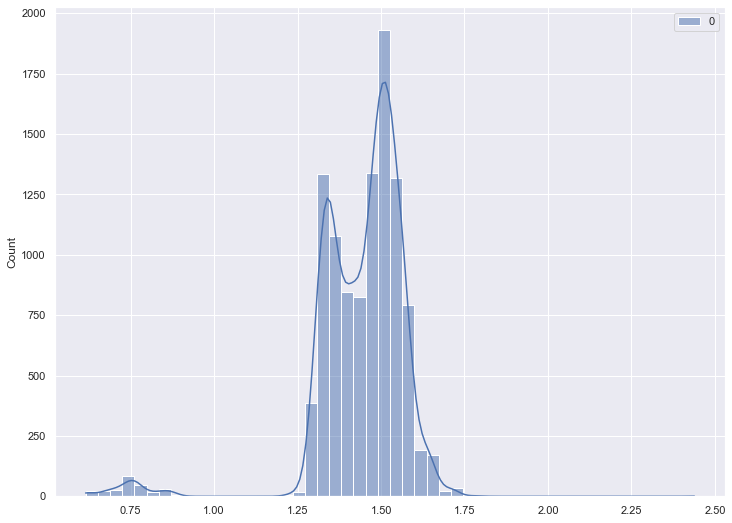

In [24]:
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('darkgrid')
sns.histplot(aspect_ratios.values(), bins=50, kde=True)

We indeed see two spikes in the distribution, corresponding to the two modes of digitization. For some later analysis we will need to separate these two categories. Let's look at the median values for the two classes. We assume that an aspect ration > 1 means that there is one page on the image, and < 1 means that there are two pages.

Let's look at the medians for each category

In [39]:
aspcrat = pd.DataFrame.from_dict(aspect_ratios, orient='index').rename(columns={0 : "aspect ratio"})

In [337]:
# Median for aspect ration of 2 pages digitized documents
median = aspcrat[aspcrat["aspect ratio"] < 1].median(axis=0)
median_2p = median["aspect ratio"]
median_2p

0.7540993653789224

In [338]:
# Median for aspect ration of 1 page digitized documents
median_1p = aspcrat[aspcrat["aspect ratio"] > 1].median(axis=0)
median_1p = median_1p["aspect ratio"]
median_1p

1.4750390990891713

## Heatmap

Now, the idea is to get a grasp of the position of the illustrations in the journals. We will use heatmaps to illustrate the distribution of the positions of illustrations in the journals.

### On two pages layouts

We start with the journals that have been digitized two pages by two pages.

In [57]:
two_p = list(aspcrat[aspcrat["aspect ratio"] < 1].index)
two_p = { k: data[k] for k in two_p }

On the heatmap, the whiter a pixel is, the more illustrations are at this place. We build it by looping over all the illustrations positions and incrementing the values when it corresponds to the illustration's place. We also resize all the images to the median aspect ratio. 

In [368]:
# A function that takes all the illustrations positions in the pages, the height and width of the figure to display
# And displays a heatmap (distribution) of the positions
def heatmap_data(dict_data, height, width):
    d = np.zeros((width, height))
    for page in dict_data.values(): # for all the pages
        for x in range(int(page["x_1"] * width), int(page["x_2"] * width)):
            for y in range(int(page["y_2"] * height), int(page["y_1"] * height)):
                d[x][y] += 1 # their is an illustration on this pixel in this page
    return d

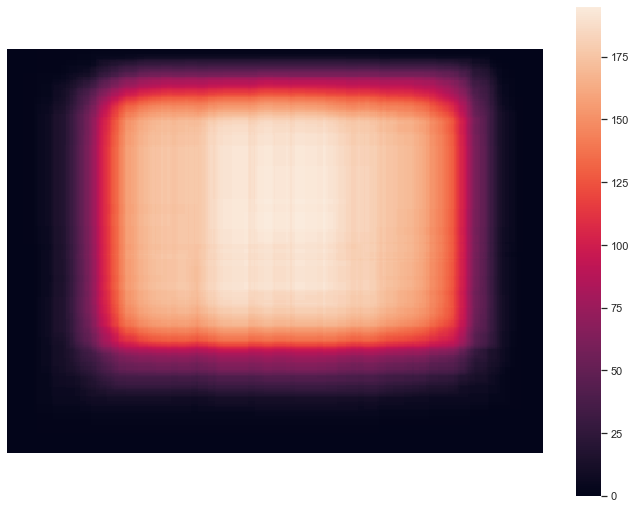

In [369]:
ax = sns.heatmap(heatmap_data(two_p, 500, int(median_2p*500)), xticklabels=False, yticklabels=False, square=True)

And we do exactly the same, but on single pages layouts.

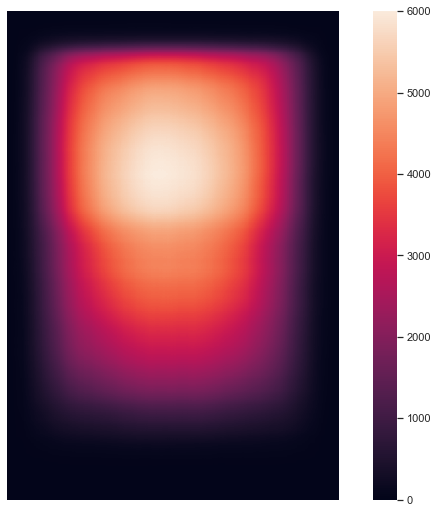

In [370]:
one_p = list(aspcrat[aspcrat["aspect ratio"] > 1].index)
one_p = { k: data[k] for k in one_p }
ax = sns.heatmap(heatmap_data(one_p, 500, int(median_1p*500)), xticklabels=False, yticklabels=False, square=True)

Because we have a lot of different pages, we can just see that for 2 pages layouts the pictures tend to be on the left and on the right, in the middle/top of the pages (it is whiter in the center because illustrations from both pages overlap). And almost the same conclusion, if not clearer, can be made on 1-page documents : the illustrations are rather on the top and in the middle of the pages. 

### Per journal

Now we have a very global idea of how the illustrations are distributed within the pages. We can reproduce this process but using more precise subset of journals. We will try to plot one heatmap per journal name.

In [372]:
# Dataframe that links the an illustration and its journal, name and id
df = pd.read_csv("./data/data.csv")

In [377]:
# Get the ids of the journals that have at least 1 illustration in them
j_ids = list(df.groupby("_journal-id").count()["id"].sort_values(ascending=False).index)
j_ids = [int(j) for j in j_ids]
j_illu_ids = []
for j in j_ids:
    one_j_ids = list(df[df["_journal-id"] == j]["id"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    if len(aspcrat.loc[one_j.keys()]) > 0 :
        j_illu_ids.append(j)

In [378]:
# Create mapping between journal id and journal name
journals_map_ids = dict()
j_illu_n_ids = []
for j in j_illu_ids:
    try:
        journals_map_ids[j] = df[df["_journal-id"]==j].iloc[0]["_journal-name"][:15]
        j_illu_n_ids.append(j)
    except:
        pass

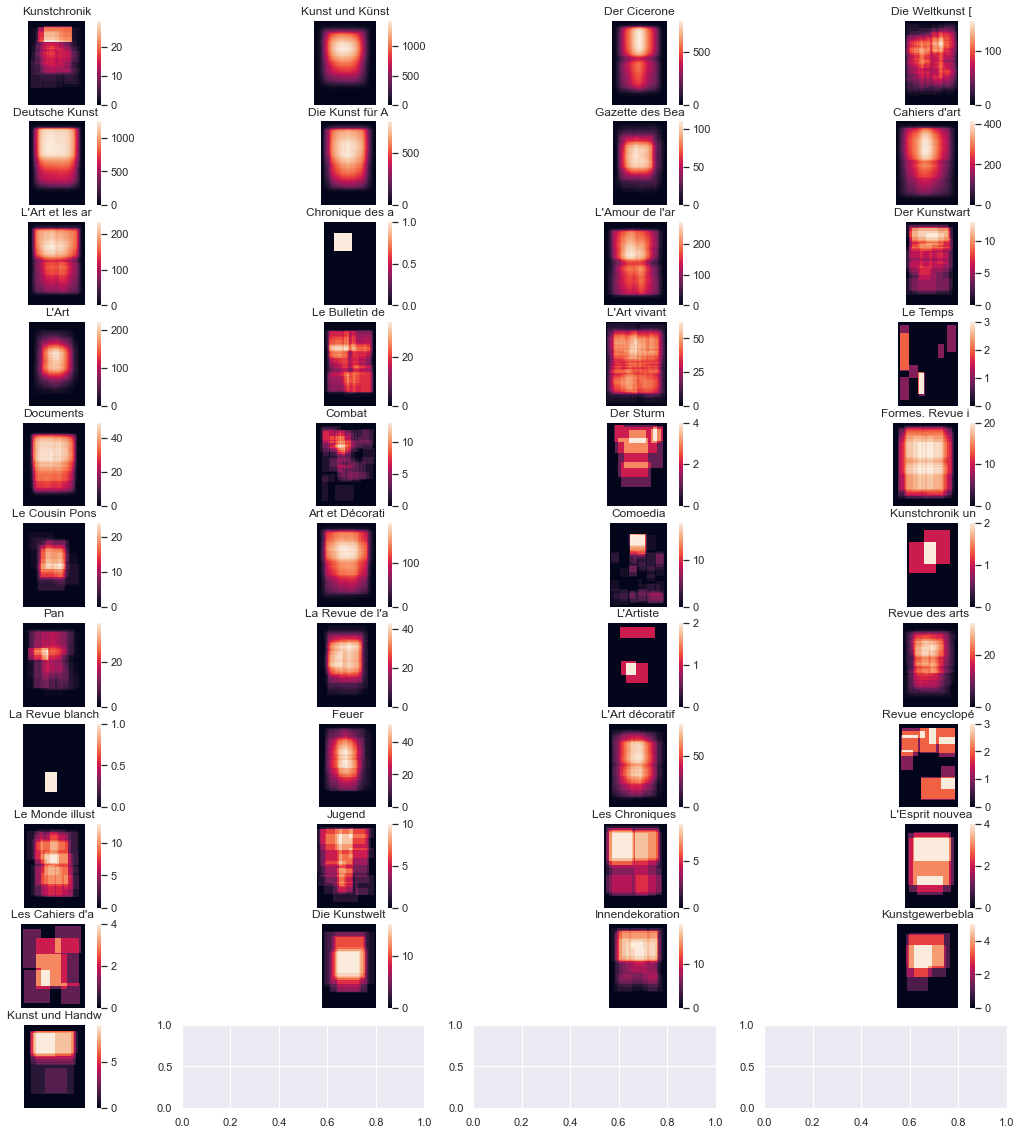

In [371]:
# Plot heatmaps for every journal
fig, axs = plt.subplots(int(len(j_illu_n_ids)/4) + 1, 4, sharex=False, sharey=False, figsize=(20,20))
for journal, ax in zip(j_illu_n_ids, axs.flatten()):
    one_j_ids = list(df[df["_journal-id"] == journal]["ID"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    median = aspcrat.loc[one_j.keys()].median(axis=0)["aspect ratio"]
    sns.heatmap(heatmap_data(one_j, 100, int(median*100)), xticklabels=False, yticklabels=False, square=True, ax=ax)
    ax.set_title(journals_map_ids[journal])

### Per illustration category

It might also be interesting to study the place of the illustrations depending on the kind of illustration they are. It is easy to proceed as we already have the categories of each illustration at our disposal.

In [403]:
# All the categories
categories = list(df.groupby("keywords").count()["id"].sort_values(ascending=False).index)

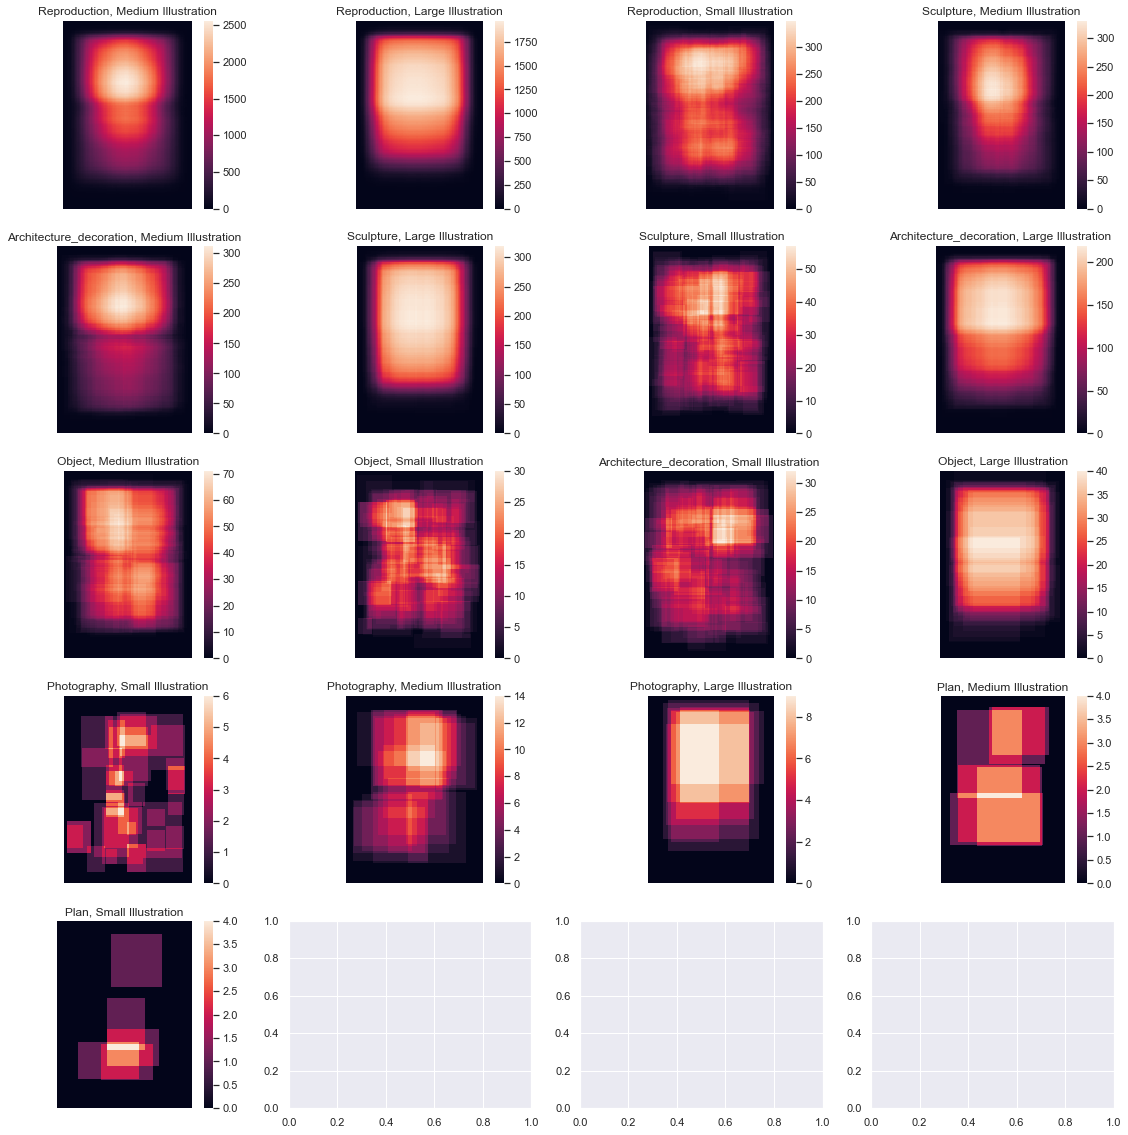

In [421]:
# Plot heatmaps for every category
fig, axs = plt.subplots(int(len(categories)/4) + 1, 4, sharex=False, sharey=False, figsize=(20,20))
for cat, ax in zip(categories, axs.flatten()):
    one_j_ids = list(df[df["keywords"] == cat]["id"])
    one_j = {k: data[k] for k in data.keys() if k in one_j_ids}
    median = aspcrat.loc[one_j.keys()].median(axis=0)["aspect ratio"]
    sns.heatmap(heatmap_data(one_j, 100, int(median*100)), xticklabels=False, yticklabels=False, square=True, ax=ax)
    ax.set_title(cat)